In [1]:
import tensorflow as tf
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from tensorflow import keras
from tensorflow.keras import layers

2023-10-26 01:27:40.849924: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!wget -nc 'https://github.com/alexdlilly/DS6050_Project/raw/main/covid.tfrecords' 
!wget -nc 'https://github.com/alexdlilly/DS6050_Project/raw/main/healthy.tfrecords' 

File ‘covid.tfrecords’ already there; not retrieving.

File ‘healthy.tfrecords’ already there; not retrieving.



### Ingest the healthy records

In [3]:
####################################################################
# Adjust the file path to be where your tf records have downloaded!#
####################################################################
filenames = ['/scratch/kzr3fb/DS6050_Project/healthy.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

2023-10-26 01:27:49.265634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46608 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [4]:
def _parse_function(example_proto):
    feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'covid': tf.io.FixedLenFeature([], tf.float32, default_value=0),
}
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_image(parsed['image_raw'])
    image = tf.reshape(image,[512,512,3])
    image = tf.image.adjust_contrast(image, 50 )
    print(parsed['covid'])
    return image,parsed['covid']

In [5]:
healthy = raw_dataset.map(_parse_function)
healthy

Tensor("ParseSingleExample/ParseExample/ParseExampleV2:0", shape=(), dtype=float32)


<_MapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

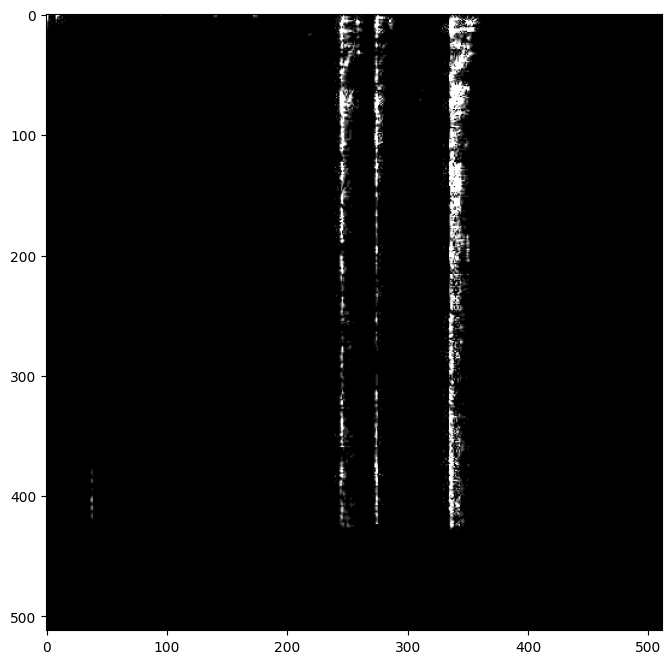

tf.Tensor(0.0, shape=(), dtype=float32)


In [6]:
for image_features in healthy.skip(100).take(1):
    image_raw = image_features[0]
    plt.figure(figsize=(8,8))
    plt.imshow(tf.transpose(image_raw)[0],cmap='gist_gray')
    plt.show()
    print(image_features[1])

### Ingest the covid records

In [7]:
####################################################################
# Adjust the file path to be where your tf records have downloaded!#
####################################################################
filenames = ['/scratch/kzr3fb/DS6050_Project/covid.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [8]:
covid = raw_dataset.map(_parse_function)

Tensor("ParseSingleExample/ParseExample/ParseExampleV2:0", shape=(), dtype=float32)


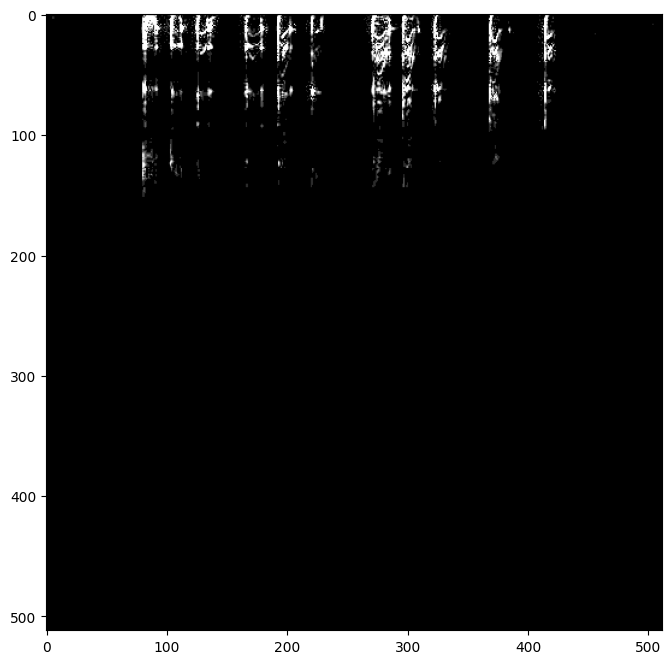

tf.Tensor(1.0, shape=(), dtype=float32)


In [9]:
for image_features in covid.skip(100).take(1):
    image_raw = image_features[0]
    plt.figure(figsize=(8,8))
    plt.imshow(tf.transpose(image_raw)[0],cmap='gist_gray')
    plt.show()
    print(image_features[1])

### Concatenate the healthy and covid records into one tensor

In [10]:
data = covid.concatenate(healthy)
# normalization_layer = layers.Rescaling(1./255)
# data = data.map(lambda x, y: (normalization_layer(x), y))
length_dataset = data.reduce(0, lambda x,_: x+1).numpy()

In [11]:
length_dataset

12833

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
train = data.take(9000)
test = data.skip(9000).take(length_dataset-9000)
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE).batch(32)
test = test.cache().prefetch(buffer_size=AUTOTUNE).batch(32)

### Define model architecture

In [26]:

inputs = keras.Input(shape=[512, 512, 3])

base_model = keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    input_shape=[512, 512, 3],
    pooling=None,
    classes=2,
    classifier_activation="sigmoid",
    include_preprocessing=True,
)

base_model.trainable = False

x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [27]:
model.compile('Adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, 16, 16, 1280)      20331360  
 al)                                                             
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 20332641 (77.56 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 20331360 (77.56 MB)
_________________________________________________________________


In [29]:
hist=model.fit(train,epochs=5,validation_data=test)

Epoch 1/5
282/282 [==============================] - 82s 251ms/step - loss: 0.2219 - accuracy: 0.0000e+00 - recall_2: 0.4803 - precision_2: 0.6549 - val_loss: 0.0079 - val_accuracy: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 2/5
282/282 [==============================] - 63s 224ms/step - loss: 0.3589 - accuracy: 0.0000e+00 - recall_2: 0.2719 - precision_2: 0.4927 - val_loss: 0.0100 - val_accuracy: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 3/5
282/282 [==============================] - 63s 224ms/step - loss: 0.3503 - accuracy: 0.0000e+00 - recall_2: 0.2800 - precision_2: 0.4992 - val_loss: 0.0109 - val_accuracy: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 4/5
281/282 [============================>.] - ETA: 0s - loss: 0.3493 - accuracy: 0.0000e+00 - recall_2: 0.2594 - precision_2: 0.4890

KeyboardInterrupt: 